# Preprocess historical-future deltas

Preprocess the layers for historical / future differences using the [iem_cru_2km_taspr_seasonal_baseline_stats](http://zeus.snap.uaf.edu:8080/rasdaman/ows?&SERVICE=WCS&VERSION=2.0.1&REQUEST=DescribeCoverage&COVERAGEID=iem_cru_2km_taspr_seasonal_baseline_stats) coverage for the historical values and the [iem_ar5_2km_taspr_seasonal](http://zeus.snap.uaf.edu:8080/rasdaman/ows?&SERVICE=WCS&VERSION=2.0.1&REQUEST=DescribeCoverage&COVERAGEID=iem_ar5_2km_taspr_seasonal) coverage for the future values. 

#### Periods of interest

We are not going to do all possible combinations at the mooment, just these:

- MRI-CGCM3 RCP 4.5, mid-century
- MRI-CGCM3 RCP 4.5, late-century
- MRI-CGCM3 RCP 8.5, mid-century
- MRI-CGCM3 RCP 8.5, late-century
- NCAR-CCSM4 RCP 4.5, mid-century
- NCAR-CCSM4 RCP 4.5, late-century
- NCAR-CCSM4 RCP 8.5, mid-century
- NCAR-CCSM4 RCP 8.5, late-century


### Setup

All of the base data will be accessed via WCS requests to the current production rasdaman server. Output data will be written to `$SCRATCH_DIR/cru_ar5_deltas/<period>_<season>_<model>_<scenario>_<varname>.tif`.

In [30]:
import os
os.environ["SCRATCH_DIR"] = "/atlas_scratch/kmredilla/iem-webapp"

In [155]:
# load libs and setup the base URL
import io
import itertools
import os
import requests
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from pathlib import Path
from affine import Affine
from rasterio.crs import CRS
from tqdm.notebook import tqdm
# lookup for the ingests
import luts

base_url = "http://zeus.snap.uaf.edu:8080/rasdaman//ows?&SERVICE=WCS&VERSION=2.0.1&REQUEST={}"
# stat index 3 is mean
wcs_url = base_url.format("GetCoverage&COVERAGEID=iem_cru_2km_taspr_seasonal_baseline_stats&SUBSET=stat(3)&FORMAT=application/netcdf")

# need wcps base str for getting mid- and late-century averages
wcps_str = (
    "ProcessCoverages&query=for $c in (iem_ar5_2km_taspr_seasonal)"
    "let $a := (condense + over $t decade({}:{}) "
    # dividend for averaging is hardcoded here at 3 (3-decade periods)
    "using $c[decade($t)] ) / 3 "
    'return encode( $a , "application/netcdf")'
)

# make the output directory
out_dir = Path(os.getenv("SCRATCH_DIR")).joinpath("cru_ar5_deltas")
out_dir.mkdir(exist_ok=True)

In [32]:
# download the CRU data
r = requests.get(wcs_url)
cru_ds = xr.open_dataset(io.BytesIO(r.content))

### Process

Iterate through the summary periods and make the two requests for averaged projection layers. For each of the two requests (two future periods), ierate over all other combinations of levels and make the requests, diff the layers, and write the results to a new stack of GeoTIFFs. 

(Note - Writing to a stack of GeoTIFFs simply for consistency with other coverages in this subfolder.)

In [153]:
# mappings based on luts.py for iteration
seasons = {
    "DJF": 0,
    "JJA": 1,
    "MAM": 2,
    "SON": 3,
}
periods = {
    "2040-2069": (3, 5),
    "2070-2099": (6, 8),
}
models = {
    "NCAR-CCSM4": 1,
    "MRI-CGCM3": 2,
}
scenarios = {
    "rcp45": 0,
    "rcp85": 2,
}
varnames = {
    "pr": 0,
    "tas": 1,
}

# hardcoded metadata pulled from CRU base data file
meta = {
    "driver": "GTiff",
    "dtype": "float32",
    "nodata": -9999.0,
    "width": 1280,
    "height": 931,
    "count": 1,
    "crs": CRS.from_epsg(3338),
    "transform": Affine(
        2000.0, 0.0, -739223.2060877988, 0.0, -2000.0, 2380412.932644147
    ),
}

In [156]:
# iterate over period to make the WCPS queries - 
# should only need to make 2 requests, one for each period
for period in periods:
    d1, d2 = periods[period]
    print(f"Downloading averaged data for {period}", end="...")
    r = requests.get(base_url.format(wcps_str.format(d1, d2)))
    ar5_ds = xr.open_dataset(io.BytesIO(r.content))
    print("done")

    # then, iterate over the other levels and write 
    levels = (seasons.keys(), models.keys(), scenarios.keys(), varnames.keys())
    print(f"Computing deltas for {period}")
    for season, model, scenario, varname in tqdm(list(itertools.product(*levels))):
        # coverage decade coordinates
        ar5_arr = ar5_ds["Gray"].sel(
            season=seasons[season],
            model=models[model],
            scenario=scenarios[scenario],
            varname=varnames[varname],
        ).values
        
        cru_arr = cru_ds["Gray"].sel(season=seasons[season], varname=varnames[varname]).values
        
        delta_arr = np.round(ar5_arr - cru_arr, 1)
        if varname == "pr":
            # do a normalized delta arr, % change from baseline for precip
            delta_arr = np.round(delta_arr / cru_arr, 2)

        # need to transpose the result due to current 
        #   ordering of X/Y axes in rasdaman coverages
        delta_arr = np.transpose(delta_arr)
        delta_arr[np.isnan(delta_arr)] = -9999
        
        fp = out_dir.joinpath(f"{varname}_{period}_{season}_{model}_{scenario}.tif")
        # deltas
        with rio.open(fp, "w", **meta) as dst:
            dst.write(delta_arr, 1)


Computing deltas for 2040-2069


  0%|          | 0/32 [00:00<?, ?it/s]

Computing deltas for 2070-2099


  0%|          | 0/32 [00:00<?, ?it/s]

### Check samples

Check some sample files:

In [135]:
def plot_sample_tif(fp):
    print("File:", fp)
    with rio.open(fp) as src:
        arr = src.read(1)
        arr[arr == src.meta["nodata"]] = np.nan
        plt.imshow(arr, interpolation="none")

File: /atlas_scratch/kmredilla/iem-webapp/cru_ar5_deltas/tas_2040-2069_DJF_NCAR-CCSM4_rcp45.tif


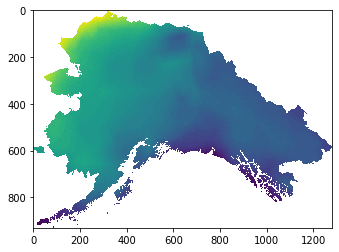

In [157]:
fp = list(out_dir.glob("tas*.tif"))[0]
plot_sample_tif(fp)

File: /atlas_scratch/kmredilla/iem-webapp/cru_ar5_deltas/pr_2040-2069_DJF_NCAR-CCSM4_rcp45.tif


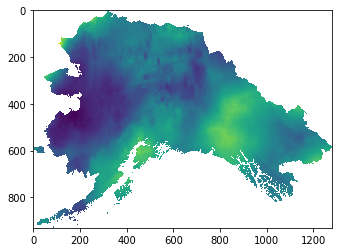

In [158]:
fp = list(out_dir.glob("pr*.tif"))[0]
plot_sample_tif(fp)

File: /atlas_scratch/kmredilla/iem-webapp/cru_ar5_deltas/tas_2040-2069_SON_NCAR-CCSM4_rcp85.tif


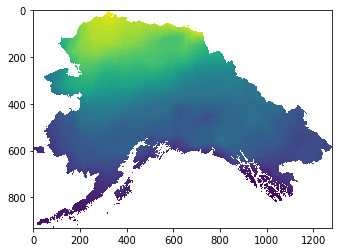

In [160]:
fp = list(out_dir.glob("tas*SON*rcp85.tif"))[0]
plot_sample_tif(fp)

File: /atlas_scratch/kmredilla/iem-webapp/cru_ar5_deltas/pr_2040-2069_MAM_MRI-CGCM3_rcp85.tif


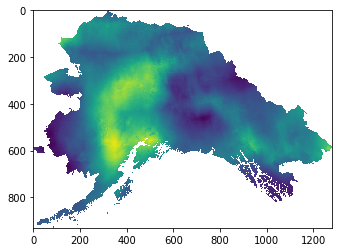

In [161]:
fp = list(out_dir.glob("pr*MAM*MRI*rcp85.tif"))[0]
plot_sample_tif(fp)